## Note allocator ver2.0
Key difference: consider about time & tempo

### Constraints
1. num of pianists, 2 hands, 5 fingers
2. spatial apart (in each hand cannot exceed one octave)
3. within one octave > same intensity > last for same period
4. hand shape

In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from midiutil import MIDIFile
from pprint import pprint

from utils import *

import copy
import random

In [2]:
## Parameters
group_num = 21 * 2 #21 pianists, 2 hands each
max_note_per_group = 5 #5 fingers

#min_pitch_gap = not set
win_length = 25e-3
min_time_gap = 0.3
min_frame_gap = int(round(min_time_gap / win_length))

In [3]:
def scale_int(intensity_map):
    #scale the intensity map(0-1) to maximum=scale
    scale = 36
    l = np.array(intensity_map)
    l = l * scale / np.amax(l)
    return l.tolist()

def intensity2sign(intensity):
    #quantize the intensity -> to dynamic sign
    int_nm = round(intensity/16)*16
    if int_nm <=16:
        return 'ppp'
    elif int_nm ==32:
        return 'pp'
    elif int_nm ==48:
        return 'p'
    elif int_nm ==64:
        return 'mp'
    elif int_nm ==80:
        return 'mf'
    elif int_nm ==96:
        return 'f'
    elif int_nm ==112:
        return 'ff'
    elif int_nm >=127:
        return 'fff'
    
def int2vel(intensity):
    #intensity(in dB) to loudness, lowest loudness is (0dB) 16  
    base = 16
    return 10**(intensity/40) * base

def picknotes(cur_key, cur_freq, cur_int, notes, notes_list):
    j = 0
    while j < len(cur_key):
        if cur_key[j] == 0:
            j += 1
            continue
        pitch = cur_key[j]
        while pitch > 88:
            pitch -= 12
        
        start = j
        ori_int = cur_int[j]
        while cur_key[j] != 0 and j < len(cur_key)-1:
            j += 1
            ori_int = max(ori_int,cur_int[j])
        end = j - 1
        if end - start < 3: 
            end = start + 3 #all to 100ms
     
        intensity = get_intensity(cur_key[j-1],cur_freq,notes_list) * ori_int
        #intensity = ori_int
        intensity = int2vel(intensity)
        #intensity = get_intensity(cur_key[j-1],cur_freq,notes_list) * 100
        intensity_sign = intensity2sign(intensity)
        notes.append(Note(pitch, start, end, intensity, intensity_sign))
        j += 1
    return notes

def remove_repetitive(notes,note_num):
    #changed
    note_set = [0]*note_num
    i = 0
    while i < len(notes):
        note = notes[i]
        if note_set[note.pitch-1] == 0:
            note_set[note.pitch-1] = [note]
        else:
            delete = False
            for n in note_set[note.pitch-1]:
                if n.start == note.start and n.end == note.end:
                    n.intensity = max(n.intensity, note.intensity)
                    n.intensity_sign = intensity2sign(n.intensity)
                    del notes[i]
                    delete = True
                    i -= 1
                    break
            if not delete:
                note_set[note.pitch-1].append(note)
        i += 1
    return notes

In [4]:
key_time = 50e-3*0.5
Fs = 48000

## picked keys
#keys = scipy.io.loadmat('MATLAB_data/23Feb_jc_key_2octave.mat')['key']
keys = scipy.io.loadmat('MATLAB_data/jw_key_2octave.mat')['key']

##freq of notes on piano
notes_list = scipy.io.loadmat('notes_112.mat')['notes'] 

##freq of t-f components
freq_list = scipy.io.loadmat('freq_480_two_octave_down.mat')['f_cropped'] 

intensity_map = scipy.io.loadmat('MATLAB_data/jw_int_2octave.mat')['filtered_int_db']
intensity_map = scale_int(intensity_map)

notes_list = notes_list.reshape(np.size(notes_list))
freq_list = freq_list.reshape(np.size(freq_list))

note_num = 112

notes = []
for i in range(np.shape(keys)[0]):
    cur_key = keys[i]
    cur_int = intensity_map[i]
    cur_freq = freq_list[i]
    notes = picknotes(cur_key, cur_freq, cur_int, notes, notes_list)

notes = sorted(notes, key = lambda note: note.start)

new_notes = remove_repetitive(notes,note_num)
#pprint(new_notes)
separate_majors(new_notes)


[pitch = 70(time = 27-30), intensity sign = p, intensity = 40.374, major = 2, channel = -1,
 pitch = 71(time = 27-30), intensity sign = ppp, intensity = 22.749, major = 1, channel = -1,
 pitch = 74(time = 27-30), intensity sign = pp, intensity = 34.595, major = 2, channel = -1,
 pitch = 75(time = 27-30), intensity sign = p, intensity = 40.682, major = 1, channel = -1,
 pitch = 75(time = 27-32), intensity sign = p, intensity = 44.894, major = 2, channel = -1,
 pitch = 75(time = 27-35), intensity sign = mp, intensity = 57.688, major = 1, channel = -1,
 pitch = 75(time = 27-33), intensity sign = p, intensity = 49.698, major = 2, channel = -1,
 pitch = 75(time = 27-31), intensity sign = pp, intensity = 36.995, major = 1, channel = -1,
 pitch = 76(time = 27-31), intensity sign = pp, intensity = 35.168, major = 1, channel = -1,
 pitch = 76(time = 27-33), intensity sign = p, intensity = 43.124, major = 1, channel = -1,
 pitch = 76(time = 27-32), intensity sign = pp, intensity = 36.912, major 

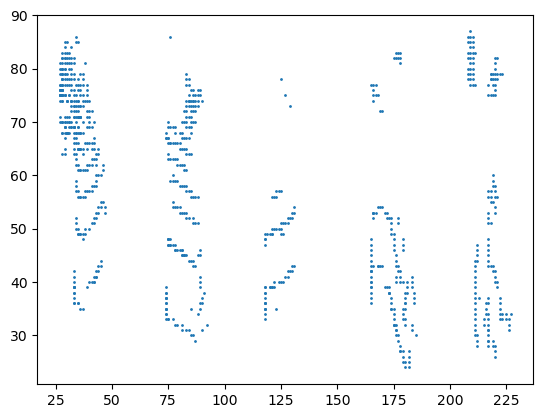

In [5]:
pprint(new_notes)
print(len(new_notes))
plot_notes(new_notes)

In [6]:
word_gap = 15
def separate_word(notes,word_gap):
    word_list = []
    ptr = 0
    for i in range(len(notes)-1):
        if notes[i+1].start - notes[i].end >= word_gap:
            word_list.append(notes[ptr:i+1])
            ptr = i + 1
        if i == len(notes) - 2:
            word_list.append(notes[ptr:])
    return word_list
    

In [7]:
def check_handshape(pitchs,righthand):
    n = len(pitchs) #number of notes in the group
    pitchs.sort()
    constraints = {'12': 9, '13': 12, '14': 12, '15': 12, '23': 7, '24': 8, '25': 10, '34': 5, '35': 7, '45': 4}
    if n < 3:
        return True
    if righthand:
        #right hand
        if n == 3:
            if pitchs[-1]-pitchs[-2] > 9: return False
            return True
        if n == 4:
            g1 = pitchs[1] - pitchs[0] 
            g2 = pitchs[2] - pitchs[1] 
            g3 = pitchs[3] - pitchs[2] 
            g4 = pitchs[2] - pitchs[0]
            g5 = pitchs[3] - pitchs[1]
            g6 = pitchs[3] - pitchs[0]
            #1234
            if g1 <= constraints['12'] and g2 <= constraints['23'] and g3 <= constraints['34'] and g4 <= constraints['13'] and g5 <= constraints['24'] and g6 <= constraints['14']:
                return True
            #1235
            elif g1 <= constraints['12'] and g2 <= constraints['23'] and g3 <= constraints['35'] and g4 <= constraints['13'] and g5 <= constraints['25'] and g6 <= constraints['15']:
                return True
            #1245
            elif g1 <= constraints['12'] and g2 <= constraints['24'] and g3 <= constraints['45'] and g4 <= constraints['14'] and g5 <= constraints['25'] and g6 <= constraints['15']:
                return True
            #1345
            elif g1 <= constraints['13'] and g2 <= constraints['34'] and g3 <= constraints['45'] and g4 <= constraints['14'] and g5 <= constraints['35'] and g6 <= constraints['15']:
                return True
            #2345
            elif g1 <= constraints['23'] and g2 <= constraints['34'] and g3 <= constraints['45'] and g4 <= constraints['24'] and g5 <= constraints['35'] and g6 <= constraints['25']:
                return True
            return False
        if n == 5:
            g1 = (pitchs[1] - pitchs[0]) <= constraints['12']
            g2 = (pitchs[2] - pitchs[0]) <= constraints['13']
            g3 = (pitchs[3] - pitchs[0]) <= constraints['14']
            g4 = (pitchs[4] - pitchs[0]) <= constraints['15']
            g5 = (pitchs[2] - pitchs[1]) <= constraints['23']
            g6 = (pitchs[3] - pitchs[1]) <= constraints['24']
            g7 = (pitchs[4] - pitchs[1]) <= constraints['25']
            g8 = (pitchs[3] - pitchs[2]) <= constraints['34']
            g9 = (pitchs[4] - pitchs[2]) <= constraints['35']
            g10 = (pitchs[4] - pitchs[3]) <= constraints['45']
            return all([g1, g2, g3, g4, g5, g6, g7, g8, g9, g10])
    else:
        #left hand
        if n == 3:
            if pitchs[1]-pitchs[0] > 9: return False
            return True
        if n == 4:
            g1 = pitchs[1] - pitchs[0] 
            g2 = pitchs[2] - pitchs[1] 
            g3 = pitchs[3] - pitchs[2] 
            g4 = pitchs[2] - pitchs[0]
            g5 = pitchs[3] - pitchs[1]
            g6 = pitchs[3] - pitchs[0]
            #4321
            if g1 <= constraints['34'] and g2 <= constraints['23'] and g3 <= constraints['12'] and g4 <= constraints['24'] and g5 <= constraints['13'] and g6 <= constraints['14']:
                return True
            #5321
            elif g1 <= constraints['35'] and g2 <= constraints['23'] and g3 <= constraints['12'] and g4 <= constraints['25'] and g5 <= constraints['13'] and g6 <= constraints['15']:
                return True
            #5421
            elif g1 <= constraints['45'] and g2 <= constraints['24'] and g3 <= constraints['12'] and g4 <= constraints['25'] and g5 <= constraints['14'] and g6 <= constraints['15']:
                return True
            #5431
            elif g1 <= constraints['45'] and g2 <= constraints['34'] and g3 <= constraints['13'] and g4 <= constraints['35'] and g5 <= constraints['14'] and g6 <= constraints['15']:
                return True
            #5432
            elif g1 <= constraints['45'] and g2 <= constraints['34'] and g3 <= constraints['23'] and g4 <= constraints['35'] and g5 <= constraints['24'] and g6 <= constraints['25']:
                return True
            return False
        if n == 5:
            g1 = (pitchs[1] - pitchs[0]) <= constraints['45']
            g2 = (pitchs[2] - pitchs[0]) <= constraints['35']
            g3 = (pitchs[3] - pitchs[0]) <= constraints['25']
            g4 = (pitchs[4] - pitchs[0]) <= constraints['15']
            g5 = (pitchs[2] - pitchs[1]) <= constraints['34']
            g6 = (pitchs[3] - pitchs[1]) <= constraints['24']
            g7 = (pitchs[4] - pitchs[1]) <= constraints['14']
            g8 = (pitchs[3] - pitchs[2]) <= constraints['23']
            g9 = (pitchs[4] - pitchs[2]) <= constraints['13']
            g10 = (pitchs[4] - pitchs[3]) <= constraints['12']
            return all([g1, g2, g3, g4, g5, g6, g7, g8, g9, g10])
    print('Group not valid')
    return False

In [8]:
def valid_note_to_allocate(note,righthand,pitch_group,high):
    test_group = pitch_group + [note.pitch]
    if not check_handshape(test_group,righthand):
        if len(test_group) == 6:
            print(pitch_group)
            print(test_group)
        return False
    low = note.pitch if pitch_group == [] else min(pitch_group)
    
    if (note.pitch not in pitch_group) and (note.pitch-low <= 12):
        #q remain: limit highest note range?
        if righthand and note.pitch < (high + 1):
            return False
        return True
    return False

def valid_to_add(candidate,current_group):
    # numel = sum([len(x) for x in candidate])
    # c1 = counter < numel
    c1 = (not empty_list(candidate))
    c2 = len(current_group) < 5
    return c1 and c2

In [9]:
def priority(note, current_allocated_note,major = 'None'):
    c1 = note.intensity_sign == current_allocated_note.intensity_sign
    c2 = (note.start == current_allocated_note.start and note.end == current_allocated_note.end)
    # c3 =  note.major == major

    if c1 and c2:
        return 1
    elif c1 and (not c2):
        return 2
    elif c2 and (not c1):
        return 3
    else: return 4


In [10]:
class Pianist:
    def __init__(self, num, starttime = None, tempo = None):
        self.num = num + 1
        self.leftnotes = []
        self.rightnotes = []
        self.starttime = starttime
        self.tempo = tempo
        self.lendtime = 0
        self.rendtime = 0
        self.high = 0

    def __repr__(self):
        return f"Pianist No.{self.num}. Tempo = {self.tempo}bpm, starting time = {self.starttime}"
    
    def addleft(self,notes):
        self.leftnotes.extend(notes)
        end = max([note.end for note in notes])
        self.lendtime = max(self.lendtime, end)

    def addright(self,notes):
        self.rightnotes.extend(notes)
        end = max([note.end for note in notes])
        self.rendtime = max(self.rendtime, end)

    def endtimes(self):
        print('Pianist No.', self.num)
        print('left ending time =', self.lendtime, 'right ending time =', self.rendtime)
        
    def printnotes(self):
        print('Pianist No.', self.num)
        print('Left hand')
        pprint(self.leftnotes)
        print('Right hand')
        pprint(self.rightnotes)

In [11]:
def init_pianists():
    pianists = []
    for i in range(21):
        pianists.append(Pianist(i))
    return pianists

In [ ]:
note1 = Note(34,0,4,0)
note2 = Note(33,0,5,0)
note3 = Note(33,0,4,0)
note = [note1, note2, note3]
minnote = min(note, key = lambda note: note.pitch)
print(minnote)

In [12]:
def allocation(cur_pianist, righthand, notes_group, tempo = None):
    current_group = []
    pitch_group = []

    if not righthand:
        endtime = cur_pianist.lendtime
    else:
        endtime = cur_pianist.rendtime
    
    start_time = endtime + min_frame_gap

    valid_notes_group = [note for note in notes_group if note.start >= start_time]
    if valid_notes_group == []:
        return notes_group, 0
    
    if not righthand:
        high = 0
        minnote = min(valid_notes_group, key = lambda note: note.pitch)
        pitch_group = [minnote.pitch]
        #major = minnote.major
        current_group.append(minnote)
        valid_notes_group.remove(minnote)
    else:
        high = cur_pianist.high
        for i in range(len(valid_notes_group)):
            if valid_notes_group[i].pitch > (high + 1):
                pitch_group = [valid_notes_group[i].pitch]
                current_group.append(valid_notes_group.pop(i))
                break
    candidate = [[],[],[],[]]   #4 priority groups for candidates         
    for current_allocated_note in current_group:
        if len(current_group) >= 5:
            break
        candidate = [[],[],[],[]]
        for note in valid_notes_group:
            if not valid_note_to_allocate(note,righthand,pitch_group,high):
                continue
            p = priority(note,current_allocated_note)
            candidate[p-1].append(note)


        for i in range(2): 
            #only consider the top two priority groups here
            #still notes in candidate list, current_group has not been filled up
            while valid_to_add(candidate[i],current_group):
                cur_candidates = candidate[i]
                shuffle_note = cur_candidates[random.randint(0, len(cur_candidates)-1)]
                candidate[i].remove(shuffle_note)
                if shuffle_note.pitch not in pitch_group:
                    if len(current_group) >= 2:
                        test_group = pitch_group + [shuffle_note.pitch]
                        if not check_handshape(test_group,righthand):
                            continue
                    pitch_group.append(shuffle_note.pitch)
                    current_group.append(shuffle_note)
                    valid_notes_group.remove(shuffle_note)

    for i in range(len(candidate)): 
        while valid_to_add(candidate[i],current_group):
            cur_candidates = candidate[i]
            shuffle_note = cur_candidates[random.randint(0, len(cur_candidates)-1)]
            candidate[i].remove(shuffle_note)
            if shuffle_note.pitch not in pitch_group:
                if len(current_group) >= 2:
                    test_group = pitch_group + [shuffle_note.pitch]
                    if not check_handshape(test_group,righthand):
                        continue
                pitch_group.append(shuffle_note.pitch)
                current_group.append(shuffle_note)
                valid_notes_group.remove(shuffle_note)

    if current_group != [] and (not righthand):
        high = max([n.pitch for n in current_group])
        cur_pianist.high = high
        
    if righthand:
        cur_pianist.addright(current_group)
    else:
        if cur_pianist.starttime == None:
            cur_pianist.starttime = min([n.start for n in current_group])
        cur_pianist.addleft(current_group)

    for note in current_group:
        notes_group.remove(note)


    return notes_group

In [18]:
def current_pianist(pianists):
    num = 0
    righthand = False
    endtime = pianists[0].lendtime
    for idx, pianist in enumerate(pianists):
        if pianist.lendtime == 0:
            return pianist, False
        elif pianist.rendtime == 0:
            return pianist, True
        
        if pianist.lendtime <= endtime:
            righthand = False
            num = idx
        elif pianist.rendtime <= endtime:
            righthand = True
            num = idx
    
    return pianists[num], righthand

In [13]:
def allocation_all(notes_group,pianists):
    righthand = False
    #notes = sorted(notes, key = lambda note: (note.start, note.pitch))
    while notes_group != []:
        previous = copy.deepcopy(notes_group)
        cur_pianist, righthand = current_pianist(pianists)
        cur_pianist.endtimes()
        
        
        #allocate left hand
        notes_group = allocation(cur_pianist, righthand, notes_group)
        #allocate right hand
        righthand = not righthand
        notes_group = allocation(cur_pianist, righthand, notes_group)

        if len(notes_group) == len(previous):
            break
    
    #补全剩余的notes


    if notes_group != []:
        print('Failed :(    ',len(notes_group), 'notes unallocated.')
        if len(notes_group) < 113:
            return True
        return False
    else:
        print('Success!')
        return True
    

In [ ]:
def allocation_all_old(notes_group):
    allocate_result=[]
    group = 1
    righthand = False #true if last group was left hand, current group is right hand, they should not overlap
    while notes_group != [] and group <= group_num:
        ## each while iteration allocate one group
        current_group = []
        pitch_group = []
        
        if not righthand:
            high = 0
            minnote = min(notes_group, key = lambda note: note.pitch)
            pitch_group = [minnote.pitch]
            major = minnote.major
            current_group.append(minnote)
            notes_group.remove(minnote)
        else:
            for i in range(len(notes_group)):
                if notes_group[i].pitch > (high + 1):
                    pitch_group = [notes_group[i].pitch]
                    current_group.append(notes_group.pop(i))
                    break
        candidate = [[],[],[],[]]   #4 priority groups for candidates         
        for current_allocated_note in current_group:
            if len(current_group) >= 5:
                break
            candidate = [[],[],[],[]]
            for note in notes_group:
                if not valid_note_to_allocate(note,righthand,pitch_group,high):
                    continue
                p = priority(note,current_allocated_note,major)
                candidate[p-1].append(note)


            for i in range(2): 
                #still notes in candidate list, current_group has not been filled up
                while valid_to_add(candidate[i],current_group):
                    cur_candidates = candidate[i]
                    shuffle_note = cur_candidates[random.randint(0, len(cur_candidates)-1)]
                    candidate[i].remove(shuffle_note)
                    if shuffle_note.pitch not in pitch_group:
                        if len(current_group) >= 2:
                            test_group = pitch_group + [shuffle_note.pitch]
                            if not check_handshape(test_group,righthand):
                                continue
                        pitch_group.append(shuffle_note.pitch)
                        current_group.append(shuffle_note)
                        notes_group.remove(shuffle_note)

        for i in range(len(candidate)): 
            while valid_to_add(candidate[i],current_group):
                cur_candidates = candidate[i]
                shuffle_note = cur_candidates[random.randint(0, len(cur_candidates)-1)]
                candidate[i].remove(shuffle_note)
                if shuffle_note.pitch not in pitch_group:
                    if len(current_group) >= 2:
                        test_group = pitch_group + [shuffle_note.pitch]
                        if not check_handshape(test_group,righthand):
                            continue
                    pitch_group.append(shuffle_note.pitch)
                    current_group.append(shuffle_note)
                    notes_group.remove(shuffle_note)


        if not righthand:
            high = max([n.pitch for n in current_group])

        allocate_result.append(current_group)

        righthand = not righthand
        group += 1 #finish allocate notes to one group, update
    
    counter = 0
    while counter < len(notes_group):
        note = notes_group[counter]
        for i, allocated_group in enumerate(allocate_result):
            if len(allocated_group) >= 4:
                continue
            if len(allocated_group) < 4:
                pitch_group = [n.pitch for n in allocated_group]
                high = max([n.pitch for n in allocate_result[i-1]]) if i % 2 == 0 else 0
                righthand = True if i % 2 == 0 else False
                if valid_note_to_allocate(note,righthand,pitch_group,high):
                    allocated_group.append(note)
                    notes_group.remove(note)
                    break
        counter += 1

    if notes_group != []:
        print('Failed :(    ',len(notes_group), 'notes unallocated.')
        return False
    else:
        print('Success!')
        return allocate_result

In [14]:
word_groups = separate_word(new_notes,word_gap)
for item in word_groups:
    print(len(item))

323
191
64
132
144


In [ ]:
pprint(word_groups[0])

In [19]:
pianists = init_pianists()
current_allocate_group = copy.deepcopy(word_groups[0])

result = allocation_all(current_allocate_group, pianists)
for pianist in pianists:
    pianist.printnotes()

Pianist No. 1
left ending time = 0 right ending time = 0
Pianist No. 2
left ending time = 0 right ending time = 0
Pianist No. 3
left ending time = 0 right ending time = 0
Pianist No. 4
left ending time = 0 right ending time = 0
Pianist No. 5
left ending time = 0 right ending time = 0
Pianist No. 6
left ending time = 0 right ending time = 0
Pianist No. 7
left ending time = 0 right ending time = 0
Pianist No. 8
left ending time = 0 right ending time = 0
Pianist No. 9
left ending time = 0 right ending time = 0
Pianist No. 10
left ending time = 0 right ending time = 0
Pianist No. 11
left ending time = 0 right ending time = 0
Pianist No. 12
left ending time = 0 right ending time = 0
Pianist No. 13
left ending time = 0 right ending time = 0
Pianist No. 14
left ending time = 0 right ending time = 0
Pianist No. 15
left ending time = 0 right ending time = 0
Pianist No. 16
left ending time = 0 right ending time = 0
Pianist No. 17
left ending time = 0 right ending time = 0
Pianist No. 18
left end

C:\Users\96326\AppData\Local\Temp\ipykernel_23012\3406167356.py:10: RuntimeWarning: overflow encountered in ubyte_scalars
  if (note.pitch not in pitch_group) and (note.pitch-low <= 12):


AttributeError: 'list' object has no attribute 'start'

In [ ]:
pianists = init_pianists()
current_allocate_group = copy.deepcopy(word_groups[0])
result = False
while not result:
    pianists = init_pianists()
    result = allocation_all(current_allocate_group, pianists)
    current_allocate_group = copy.deepcopy(word_groups[0])
    random.shuffle(current_allocate_group)
    

In [ ]:
result_all = []
for i in range(2,5):
    print(i)
    current_allocate_group = copy.deepcopy(word_groups[i])
    #random.shuffle(current_allocate_group)
    result = False
    while not result:
        result = allocation_all(current_allocate_group)
        current_allocate_group = copy.deepcopy(word_groups[i])
        random.shuffle(current_allocate_group)
    result_all.append(result)
   

In [ ]:
print(result_all)

In [ ]:
current_allocate_group = copy.deepcopy(word_groups[4])
result = False
while not result:
    result = allocation(current_allocate_group)
    current_allocate_group = copy.deepcopy(word_groups[4])
    random.shuffle(current_allocate_group)


In [ ]:
plot_notes(new_notes)
plt.show()
word_groups = separate_word(new_notes)
for g in word_groups:
    plot_notes(g)
plt.show()

In [ ]:
mf = MIDIFile(2)     # track number
time = 0    # start at the beginning
mf.addTrackName(0, time, "Right")
mf.addTrackName(1, time, "Left")
mf.addTempo(0, time, 1200)
mf.addTempo(1, time, 1200)

In [ ]:
for i in range(2):    
    for note in final_allocation2[1-i]:
        # v = int(50+note.sign()*12.5)
        v = int(20+note.sign()*20)
        mf.addNote(i,i,note.pitch+20, note.start, note.end-note.start+1,v)

In [ ]:
with open("midifile/23Feb_allocation2.mid", 'wb') as outf:
   mf.writeFile(outf)

In [ ]:
import numpy as np
array = np.array(result_all,dtype=object)
np.save("allocation_result_1Mar.npy", array)